# How is ecosystem sensitivity to rainfall changing in semi-arid Australia?

Replicating Poulter et al. 2014


In [1]:
import os
import sys
import warnings
import xarray as xr
import seaborn as sb
import xarray as xr
import geopandas as gpd
from scipy import stats
from scipy.stats import gaussian_kde
import xskillscore as xs
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import odc.geo.xr
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry, CRS
from matplotlib.patches import Patch

warnings.simplefilter('ignore')
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

%matplotlib inline

In [2]:
# import sys
# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from _utils import start_local_dask

# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters

In [3]:
base = '/g/data/os22/chad_tmp/AusENDVI/data/'
ndvi_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'

t_range='1982', '2013'
crs='EPSG:4326'

ys1, ys2, = '1982','1998'
ye1, ye2 = '1999','2013'
season='MAM'

## Open data

In [4]:
pku = xr.open_dataarray(f'{base}/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
pku = pku.rename('NDVI')
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+'NDVI_harmonization/AVHRR_GIMMS3g_v1.1_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

#because modis is joined we can just load the final dataset and clip out 2000 onwards
modis = assign_crs(xr.open_dataset(ndvi_path)['AusENDVI_clim_MCD43A4'], crs='EPSG:4326')
modis = modis.sel(time=slice('2000-03', '2013'))
modis = assign_crs(modis, crs=crs)
modis.attrs['nodata'] = np.nan
modis = modis.rename('NDVI')

ds = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/NDVI_harmonization/LGBM/AusENDVI_clim_gapfill_1982_2013.nc')['AusENDVI_clim']
ds = assign_crs(ds, crs='EPSG:4326')
ds = ds.sel(time=slice('1982','2013'))
ds = ds.rename('NDVI')
ds.attrs['nodata'] = np.nan

# ause = assign_crs(xr.open_dataset(ndvi_path)['AusENDVI_clim_MCD43A4'], crs='EPSG:4326')
syn = assign_crs(xr.open_dataset(base+'/synthetic/NDVI/NDVI_CLIM_synthetic_5km_monthly_1982_2022.nc')['NDVI'], crs='EPSG:4326')

ls = xr.open_dataset(base+'/NDVI_harmonization/Landsat_NDVI_5km_monthly_1988_2012.nc')['NDVI']
ls = assign_crs(ls, crs=crs)
ls.attrs['nodata'] = np.nan

rain = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = rain.sel(time=slice('1982', '2022'))
rain = assign_crs(rain, crs=crs)
rain.attrs['nodata'] = np.nan

## Harmonise

In [5]:
ds = ds.odc.reproject(pku.odc.geobox, resampling='average')
modis = modis.odc.reproject(pku.odc.geobox, resampling='average')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')
syn = syn.odc.reproject(pku.odc.geobox, resampling='average')
gimms = gimms.odc.reproject(pku.odc.geobox, resampling='bilinear')
ls = ls.odc.reproject(pku.odc.geobox, resampling='average')

gimms = round_coords(gimms)
ds = round_coords(ds)
modis = round_coords(modis)
pku = round_coords(pku)
rain = round_coords(rain)
syn = round_coords(syn)
ls = round_coords(ls)

#gapfill PKU the same as our product
obs_monthly = pku.groupby('time.month').mean()
obs_anom = pku.groupby('time.month') - obs_monthly
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
pku = obs_anom.groupby('time.month') + obs_monthly
pku = pku.drop('month')
pku = pku.fillna(syn.sel(time=pku.time))

# GIMMS3g gapfill with climatology (gimms mean NDVI larger than syn)
gimms_clim = gimms.groupby('time.month').mean()
gimms = gimms.fillna(obs_monthly).drop_vars(['month', 'spatial_ref']).isel(month=1)

#Landsats
# obs_monthly = ls.groupby('time.month').mean()
# obs_anom = ls.groupby('time.month') - obs_monthly
# obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
# ls = ls.groupby('time.month') + obs_monthly
# ls = ls.drop('month')
# ls = ls.fillna(syn.sel(time=ls.time))

ds_mask =  ~np.isnan(ds)
pku_mask =  ~np.isnan(pku)
gimms_mask =  ~np.isnan(gimms)
# ls_mask =  ~np.isnan(ls)

# #combine masks
mask = (ds_mask & pku_mask & gimms_mask)

ds = ds.where(mask)
gimms = gimms.where(mask)
pku = pku.where(mask)
modis = modis.where(mask.sel(time=modis.time))
# ls = ls.where(mask.sel(time=ls.time))
rain = rain.where(mask)

### Clip time

In [6]:
pku = pku.sel(time=slice(t_range[0], t_range[1]))
rain = rain.sel(time=slice(t_range[0], t_range[1]))
ds = ds.sel(time=slice(t_range[0], t_range[1]))
gimms = gimms.sel(time=slice(t_range[0], t_range[1]))


## Clip to season & semi-arid regions

In [7]:
def months_filter(ds, season):
    season_dict={'DJF':[12,1,2],
                'MAM':[3,4,5],
                'JJA':[6,7,8],
                'SON':[9,10,11],
                'Annual':list(range(1,13))
                }
    return ds[ds.time.dt.month.isin(season_dict[season])]

ds = months_filter(ds, season)
gimms = months_filter(gimms, season)
pku = months_filter(pku, season)
ls = months_filter(ls, season)
rain = months_filter(rain, season)
modis = months_filter(modis, season)

In [8]:
#open geojson
gdf = gpd.read_file('/g/data/os22/chad_tmp/AusENDVI/data/bioclimatic_regions.geojson')
gdf = gdf[gdf['region_name'].isin(['Savanna','Desert'])]
gdf['diss'] = 1
gdf = gdf.dissolve(by='diss',aggfunc='sum').reset_index(drop=True)

# # Extract the feature's geometry as a datacube geometry object
geom = Geometry(geom=gdf.geometry[0], crs=gdf.crs)

# # Mask dataset to set pixels outside the polygon to `NaN`
ds = ds.odc.mask(poly=geom)
gimms = gimms.odc.mask(poly=geom)
rain = rain.odc.mask(poly=geom)
pku = pku.odc.mask(poly=geom)
modis = modis.odc.mask(poly=geom)
ls = ls.odc.mask(poly=geom)

## Trends in annual averages

In [9]:
ds_1d = ds.resample(time='YS').mean().mean(['latitude', 'longitude'])#.sel(time=slice('2000','2013'))
gimms_1d = gimms.resample(time='YS').mean().mean(['latitude', 'longitude'])#.sel(time=slice('2000','2013'))
rain_1d = rain.resample(time='YS').mean().mean(['latitude', 'longitude'])#.sel(time=slice('2000','2013'))
pku_1d = pku.resample(time='YS').mean().mean(['latitude', 'longitude'])#.sel(time=slice('2000','2013'))
modis_1d = modis.resample(time='YS').mean().mean(['latitude', 'longitude'])
ls_1d = ls.resample(time='YS').mean().mean(['latitude', 'longitude'])

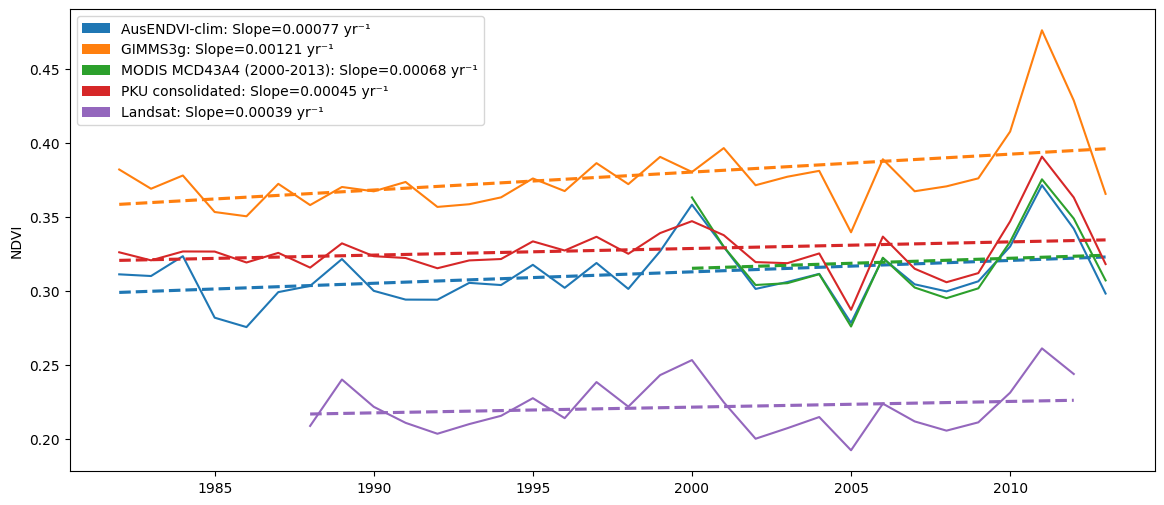

In [10]:
dss = [ds_1d, gimms_1d, modis_1d, pku_1d, ls_1d] #modis_1d,
name = ['AusENDVI-clim','GIMMS3g','MODIS MCD43A4 (2000-2013)','PKU consolidated', 'Landsat'] #'MODIS',
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors[0:-1]

fig, ax = plt.subplots(1,1, figsize=(14,6))

slopes =[]
for xx, n, c in zip(dss, name, colors):
    
    df = xx.to_dataframe(name=n).reset_index(drop=True)
    df.index = xx.time.dt.year.values
    df = df.reset_index()
    df = df.rename({'index':'Year'},axis=1)
    df=df.dropna()
    
    s, i, r, p, se = stats.linregress(df['Year'], df[n])
    slopes.append(s)
    sb.regplot(y=n, x='Year', data=df, ax=ax, ci=None, label=n, fit_reg=True, color=c,
                 line_kws={'linestyle':'--'}, #'label':"y={0:.5f}x+{1:.4f}".format(s,i), 
                 scatter_kws ={'s':0}
              )

    sb.lineplot(y=n, x='Year', data=df, ax=ax, color=c)

#legend with slopes
labels = []
for n,s in zip(name,slopes):
    labels.append(n+": Slope={0:.5f} yr⁻¹".format(s))

ax.legend(
        [Patch(facecolor=c) for c in colors], 
        labels, 
        loc='best'
    )

plt.title(None);
ax.set_xlabel(None);
ax.set_ylabel('NDVI');
# fig.savefig('/g/data/os22/chad_tmp/AusENDVI/results/figs/compare_annual_average_trends.png',
#             bbox_inches='tight', dpi=300)

## Anomalies

In [11]:
def anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m: (x - m),
            ds.groupby("time.month"),
            ds.groupby("time.month").mean()
    )

pku_anom = anomalies(pku)
modis_anom = anomalies(modis)
rain_anom = anomalies(rain)
ds_anom = anomalies(ds)
gimms_anom = anomalies(gimms)
ls_anom = anomalies(ls).drop_vars('spatial_ref')

#couple of pesky infs crept in
modis_anom = modis_anom.where(~np.isinf(modis_anom))

## Derive NDVI-rain relationships

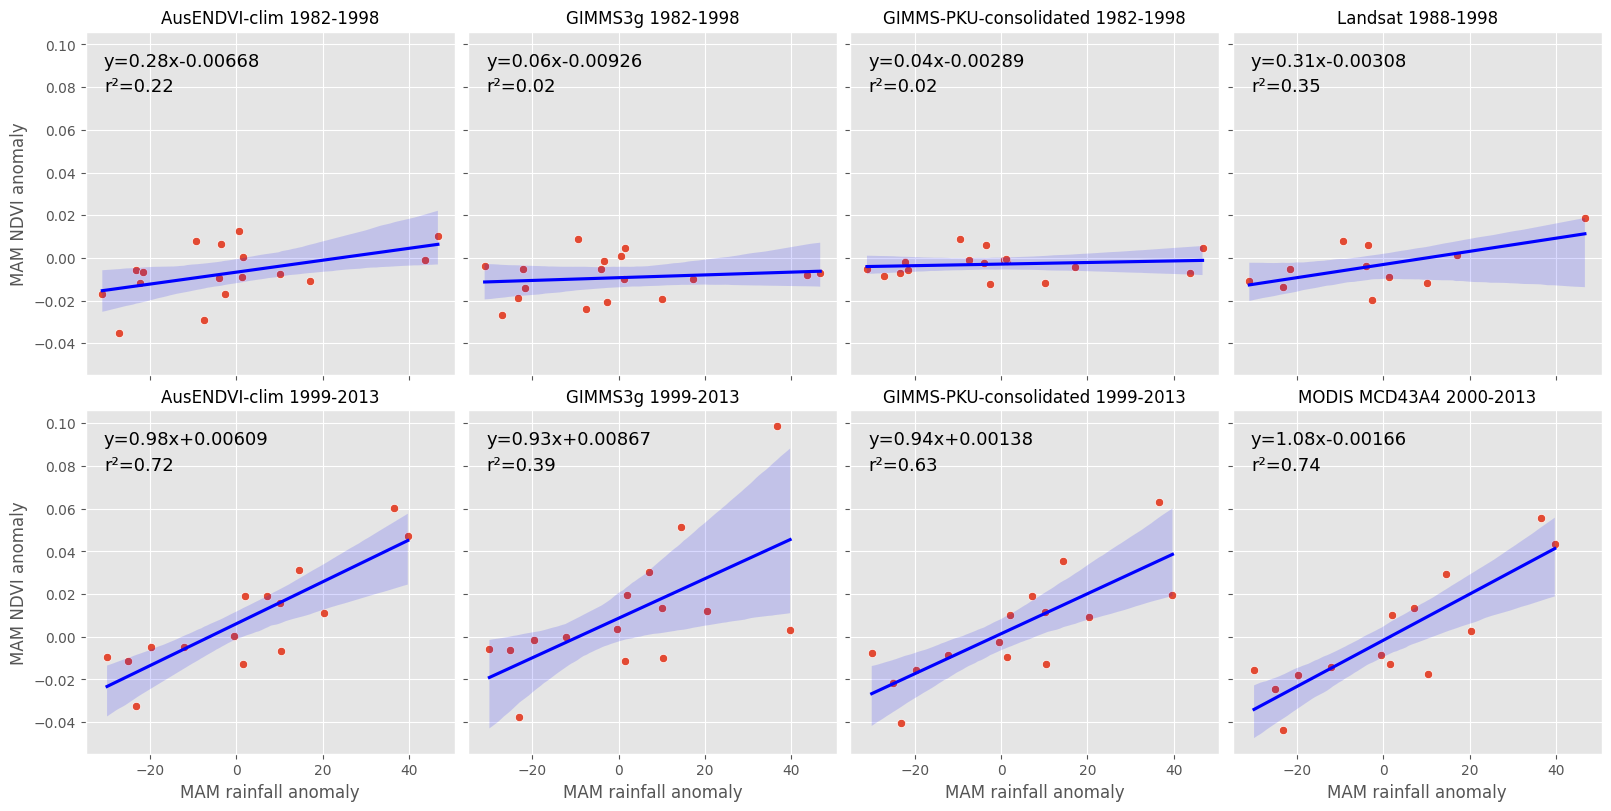

In [21]:
ndvi_data = [ds_anom.sel(time=slice(ys1, ys2)),
             gimms_anom.sel(time=slice(ys1, ys2)),
             pku_anom.sel(time=slice(ys1, ys2)),
             ls_anom.sel(time=slice('1988','1998')),
             
             ds_anom.sel(time=slice(ye1, ye2)),
             gimms_anom.sel(time=slice(ye1, ye2)),
             pku_anom.sel(time=slice(ye1, ye2)),
             modis_anom,
            ]

rain_data = [rain_anom.sel(time=slice(ys1, ys2)),
             rain_anom.sel(time=slice(ys1, ys2)),
             rain_anom.sel(time=slice(ys1, ys2)),   
             rain_anom.sel(time=slice('1988','1998')), 
             
             rain_anom.sel(time=slice(ye1, ye2)),
             rain_anom.sel(time=slice(ye1, ye2)),
             rain_anom.sel(time=slice(ye1, ye2)),
             rain_anom.sel(time=slice(ye1, ye2)), 
            ]

names=[f'AusENDVI-clim {ys1}-{ys2}',f'GIMMS3g {ys1}-{ys2}',f'GIMMS-PKU-consolidated {ys1}-{ys2}','Landsat 1988-1998',
       f'AusENDVI-clim {ye1}-{ye2}',f'GIMMS3g {ye1}-{ye2}',f'GIMMS-PKU-consolidated {ye1}-{ye2}', 'MODIS MCD43A4 2000-2013']

with plt.style.context('ggplot'):
    fig,axes=plt.subplots(2,4, figsize=(16,8), sharey=True, sharex=True, layout='constrained')
    for ax, ndvi, r, n in zip(axes.ravel(), ndvi_data, rain_data, names):
        
            # plot_df = r.rename('rain').rolling(time=12,
            #             min_periods=12).mean().mean(['latitude','longitude']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)
            plot_df = r.rename('rain').resample(time='YS').sum().mean(['latitude','longitude']).to_dataframe()
            # plot_df['ndvi'] = ndvi.rolling(time=12,
            #             min_periods=12).mean().mean(['latitude','longitude']).to_dataframe(name='ndvi').drop(['spatial_ref', 'month'], axis=1)
            try:    
                plot_df['ndvi'] = ndvi.resample(time='YS').mean().mean(['latitude','longitude']).drop_vars('spatial_ref').to_dataframe(name='ndvi')
            except:
                plot_df['ndvi'] = ndvi.resample(time='YS').mean().mean(['latitude','longitude']).to_dataframe(name='ndvi')
            
            plot_df=plot_df.dropna()
            
            obs, pred = plot_df['rain'].values, plot_df['ndvi'].values
        
            s, i, r_value, p_value, std_err = stats.linregress(obs,pred)
            r2 = r_value**2
            s = s*1000
            sb.scatterplot(data=plot_df, x='rain',y='ndvi', alpha=1.0, ax=ax, cmap='magma')
            sb.regplot(data=plot_df, x='rain',y='ndvi', scatter=False, color='blue', ax=ax)

            if i<0:
                ax.text(.05, .9, f'y={s:.2f}x{i:.5f}', transform=ax.transAxes, fontsize=13)
            else:
                ax.text(.05, .9, f'y={s:.2f}x+{i:.5f}',transform=ax.transAxes, fontsize=13)
            
            ax.text(.05, .825, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),transform=ax.transAxes, fontsize=13)
        
            ax.set_ylabel(f'{season} NDVI anomaly')
            ax.set_xlabel(f'{season} rainfall anomaly')
            ax.set_title(n, fontsize=12)

# fig.savefig(f'/g/data/os22/chad_tmp/AusENDVI/results/figs/rainfall_ndvi_relationships.png',
#             bbox_inches='tight', dpi=300);